<a href="https://colab.research.google.com/github/DivineOmega/clip-interrogator/blob/main/clip_interrogator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Interrogator by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

<br>

What do the different OpenAI CLIP models see in an image? What might be a good text prompt to create similar images using CLIP guided diffusion or another text to image model? The CLIP Interrogator is here to get you answers!

<br>

If this notebook is helpful to you please consider buying me a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following me on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [41]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-bb403d9a-9845-32f8-7c2a-26befb904fc4)


In [83]:
#@title Setup
!pip3 install ftfy regex tqdm transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!pip3 install git+https://github.com/openai/CLIP.git
!git clone https://github.com/pharmapsychotic/clip-interrogator.git

import clip
import gc
import numpy as np
import os
import pandas as pd
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def load_list(filename):
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def rank(model, image_features, text_array, top_count=1):
    top_count = min(top_count, len(text_array))
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = torch.zeros((1, len(text_array))).to(device)
    for i in range(image_features.shape[0]):
        similarity += (100.0 * image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)
    similarity /= image_features.shape[0]

    top_probs, top_labels = similarity.cpu().topk(top_count, dim=-1)  
    return [(text_array[top_labels[0][i].numpy()], (top_probs[0][i].numpy()*100)) for i in range(top_count)]

def interrogate(image, models):

    if len(models) != 1:
        print("You must select exactly one model.")
        return

    table = []
    #bests = [[('',0)]]*5

    model_name = models[0]

    print(f"Interrogating with {model_name}...")
    model, preprocess = clip.load(model_name)
    model.cuda().eval()

    images = preprocess(image).unsqueeze(0).cuda()
    with torch.no_grad():
        image_features = model.encode_image(images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

    ranks = [
        rank(model, image_features, [f"{x} photo" for x in focal_lengths]),
        rank(model, image_features, [f"photo of a {x} person" for x in styles]),
        rank(model, image_features, [f"photo of a {x} person" for x in ages]),
        rank(model, image_features, [f"photo of a {x}" for x in genders]),
        rank(model, image_features, [f"photo of a person with {x} hair" for x in hair_lengths]),
        rank(model, image_features, [f"photo of a person with {x} hair" for x in hair_colours]),
        rank(model, image_features, [f"photo of a person with a {x} shaped_face" for x in face_shapes]),
        rank(model, image_features, [f"photo of a person with {x} eyes" for x in eye_colours]),
        rank(model, image_features, [f"photo of a person wearing a {x}" for x in top_garments]),
        rank(model, image_features, [f"photo of a person wearing a {x}" for x in bottom_garments]),
        rank(model, image_features, [f"photo of a person wearing a {x}" for x in outer_garments])
        # rank(model, image_features, flavors, top_count=3)
    ]

    #for i in range(len(ranks)):
    #    confidence_sum = 0
    #    for ci in range(len(ranks[i])):
    #        confidence_sum += ranks[i][ci][1]
    #    if confidence_sum > sum(bests[i][t][1] for t in range(len(bests[i]))):
    #        bests[i] = ranks[i]

    row = [model_name]
    for r in ranks:
        row.append(', '.join([f"{x[0]} ({x[1]:0.1f}%)" for x in r]))

    table.append(row)

    gc.collect()

    display(pd.DataFrame(table, columns=["Model", "Focal Length", "Style", "Age", "Gender", "Hair Length", "Hair Colour", "Face Shape", "Eye Colour", "Top Garment", "Bottom Garment", "Outer Garment"]))

    focal_length = find_original_attribute(ranks[0][0][0], focal_lengths)
    style = find_original_attribute(ranks[1][0][0], styles)
    age = find_original_attribute(ranks[2][0][0], ages)
    gender = find_original_attribute(ranks[3][0][0], genders)
    hair_length = find_original_attribute(ranks[4][0][0], hair_lengths)
    hair_colour = find_original_attribute(ranks[5][0][0], hair_colours)
    face_shape = find_original_attribute(ranks[6][0][0], face_shapes)
    eye_colour = find_original_attribute(ranks[7][0][0], eye_colours)
    top_garment = find_original_attribute(ranks[8][0][0], top_garments)
    bottom_garment = find_original_attribute(ranks[9][0][0], bottom_garments)
    outer_garment = find_original_attribute(ranks[10][0][0], outer_garments)

    garments = []
    if (top_garment != 'no top garment'):
        garment_colour_rank = rank(model, image_features, [f"photo of a person wearing a {x} {top_garment}" for x in garment_colours])
        garment_colour = find_original_attribute(garment_colour_rank[0][0], garment_colours)
        garments.append(garment_colour + ' ' + top_garment)
    if (bottom_garment != 'no bottom garment'):
        garment_colour_rank = rank(model, image_features, [f"photo of a person wearing a {x} {bottom_garment}" for x in garment_colours])
        garment_colour = find_original_attribute(garment_colour_rank[0][0], garment_colours)
        garments.append(garment_colour + ' ' +bottom_garment)
    if (outer_garment != 'no outer garment'):
        garment_colour_rank = rank(model, image_features, [f"photo of a person wearing a {x} {outer_garment}" for x in garment_colours])
        garment_colour = find_original_attribute(garment_colour_rank[0][0], garment_colours)
        garments.append(garment_colour + ' ' + outer_garment)

    wearing = ''
    if (len(garments) > 0):
        wearing += 'wearing ';
        for i, garment in enumerate(garments, start=0):
            wearing += f'a {garment}'
            if (i < len(garments)-1):
              wearing += ' and '

    print(f"\n\n{focal_length} photo of a {style} {age} {gender} with {hair_length} {hair_colour} hair, a {face_shape} face and {eye_colour} eyes {wearing}. dof. bokeh. extremely detailed. Nikon D850.")

def find_original_attribute(best, original_attributes):
  for original_attribute in original_attributes:
        if (original_attribute in best):
            return original_attribute
            

data_path = "../clip-interrogator/data/"

focal_lengths = ['18mm', '24mm', '35mm', '55mm', '85mm', '105mm', '135mm', '200mm'];
styles = ['professional', 'beautiful', 'attractive','sexy naked', 'sexy', 'naked', 'ugly', 'average looking', 'stylish', 'glamourous', 'elegant', 'cyberpunk', 'steampunk', 'handsome', 'goth', 'emo', 'alternative', 'punk', 'pretty', 'cute']
ages = ['18 year old', '20 year old', '30 year old', '40 year old', '50 year old', '60 year old', '70 year old', '80 year old', '90 year old', '100 year old']
genders = ['woman', 'man']
hair_lengths = ['waist length', 'shoulder length', 'pixie cut', 'very long', 'very short', 'long', 'medium', 'short']
hair_colours = ['bleach blond', 'blond', 'light brown', 'dark brown', 'brown', 'black', 'bright red', 'dark red', 'red', 'ginger', 'white', 'grey', 'gray', 'green', 'blue', 'cyan', 'orange', 'purple', 'pink']
face_shapes = ['diamond', 'heart', 'oval', 'rectangular', 'round', 'square']
eye_colours = ['dark brown', 'chocolate brown', 'light brown', 'light blue', 'dark blue', 'light green', 'dark green', 'blue', 'brown', 'grey', 'gray', 'green']
top_garments = ['no top garment', 'headscarf', 'hijab', 'hooded garment' 'dress', 'long dress', 'short dress', 'tank top', 'tube top', 'crop top', 'halter top', 'off-the-shoulder top', 'one-shoulder top', 't-shirt', 'blouse', 'button-down shirt', 'polo shirt', 'bikini', 'bra', 'shirt and tie', 'shirt', 'catsuit']
bottom_garments = ['no bottom garment', 'short denim shorts', 'short ripped denim shorts', 'short demin dress', 'denim shorts', 'denim dress', 'skirt', 'short skirt', 'long skirt', 'skort', 'shorts', 'short shorts', 'long shorts', 'jeans', 'capris', 'pants', 'trousers']
outer_garments = ['no outer garment', 'fancy dress', 'super hero costume', 'wonder woman costume', 'superman constume', 'american flag', 'united kingdom flag', 'flag', 'coat', 'cardigan', 'jacket', 'hoodie', 'robe', 'suit jacket']
garment_colours = ['silver and gold metallic', 'polka dot', 'dotted', 'horizontally striped', 'vertically striped', 'stripped', 'cosplay', 'black and white', 'leopard print', 'tiger print', 'lion print', 'animal print', 'traditional', 'american', 'british', 'silver metallic', 'red metallic', 'green metallic', 'blue matallic', 'metallic', 'silver sequinned', 'sequinned', 'intricately patterned', 'frilly white', 'frilly black', 'frilly', 'geometric', 'patterned', 'flowery', 'floral', 'blue leather', 'black leather', 'leather', 'red', 'green', 'blue', 'white', 'black', 'orange', 'yellow', 'purple', 'pink', 'grey', 'gray', 'brown']


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y8c_gpjv
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-y8c_gpjv
fatal: destination path 'clip-interrogator' already exists and is not an empty directory.


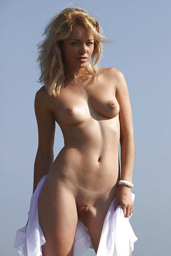

Interrogating with ViT-L/14...


,Model,Focal Length,Style,Age,Gender,Hair Length,Hair Colour,Face Shape,Eye Colour,Top Garment,Bottom Garment,Outer Garment
0,ViT-L/14,200mm photo (48.4%),photo of a sexy naked person (63.5%),photo of a 20 year old person (18.6%),photo of a woman (99.4%),photo of a person with waist length hair (49.1%),photo of a person with bleach blond hair (50.1%),photo of a person with a heart shaped_face (35...,photo of a person with grey eyes (18.7%),photo of a person wearing a no top garment (48...,photo of a person wearing a no bottom garment ...,photo of a person wearing a no outer garment (...




200mm photo of a sexy naked 20 year old woman with waist length bleach blond hair, a heart face and grey eyes . dof. bokeh. extremely detailed. Nikon D850.


In [84]:
#@title Interrogate!

#@markdown 

#@markdown #####**Image:**

image_path_or_url = "https://imgs.search.brave.com/Dr03nlYS0N_3nIcZwK8e-OSUKD0PikodMgFZ69z6C48/rs:fit:500:748:1/g:ce/aHR0cHM6Ly90aHVt/Yi1wNy54aGNkbi5j/b20vYS9NSFN2QmNL/dUozZTFaLU8tc0lW/MVlBLzAwMC8wMzQv/MzM2LzEwN18xMDAw/LmpwZw" #@param {type:"string"}

#@markdown 

#@markdown #####**CLIP models:**

#@markdown For [StableDiffusion](https://stability.ai/blog/stable-diffusion-announcement) you can just use ViTL14<br>
#@markdown For [DiscoDiffusion](https://colab.research.google.com/github/alembics/disco-diffusion/blob/main/Disco_Diffusion.ipynb) and 
#@markdown [JAX](https://colab.research.google.com/github/huemin-art/jax-guided-diffusion/blob/v2.7/Huemin_Jax_Diffusion_2_7.ipynb) enable all the same models here as you intend to use when generating your images

ViTB32 = False #@param{type:"boolean"}
ViTB16 = False #@param{type:"boolean"}
ViTL14 = True #@param{type:"boolean"}
ViTL14_336px = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = False #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

models = []
if ViTB32: models.append('ViT-B/32')
if ViTB16: models.append('ViT-B/16')
if ViTL14: models.append('ViT-L/14')
if ViTL14_336px: models.append('ViT-L/14@336px')
if RN101: models.append('RN101')
if RN50: models.append('RN50')
if RN50x4: models.append('RN50x4')
if RN50x16: models.append('RN50x16')
if RN50x64: models.append('RN50x64')

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

thumb = image.copy()
thumb.thumbnail([256, 256])
display(thumb)

interrogate(image, models=models)
